## Classification Metrics for Binary Classification

**Dataset (used in this notebook):**  
[Kaggle — Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, precision_score, recall_score,
    precision_recall_curve, average_precision_score, f1_score, fbeta_score,
    roc_curve, roc_auc_score
)

# display settings
plt.rcParams["figure.figsize"] = (8,6)
np.random.seed(42)

In [2]:
import os
DATA_PATH = "./creditcard.csv"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print(df['Class'].value_counts())
df.head()

Shape: (284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## About the Dataset

The dataset has a highly imbalanced target `Class`:
- `0` = normal transaction
- `1` = fraud

We'll use features as provided (V1..V28, Time, Amount) and `Class` as the target.


In [3]:
# Prepare train/test split (stratified to keep imbalance)

X = df.drop(columns=['Class'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))

Train shape: (199364, 30)  Test shape: (85443, 30)
Train class distribution:
 Class
0    0.998275
1    0.001725
Name: proportion, dtype: float64
Test class distribution:
 Class
0    0.998268
1    0.001732
Name: proportion, dtype: float64


## Baseline model

We'll train a **RandomForestClassifier** (simple, robust) and use predicted probabilities (`predict_proba`)
to illustrate threshold effects, PR curve, ROC, etc. 

In [4]:
# Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# predicted probabilities (positive class)
y_scores = rf.predict_proba(X_test)[:, 1]

# default threshold 0.5 predictions
y_pred_05 = (y_scores >= 0.5).astype(int)

## Accuracy and limitation of accuracy

**Definition:**  

$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

**Limitation:** 
Accuracy can be misleading for imbalanced datasets. For example, if positives are 0.5% of the data,
a classifier that predicts "negative" for every instance gets ≈99.5% accuracy but detects zero positives.


In [5]:
# Accuracy (from scratch and sklearn)
def accuracy_from_scratch(y_true, y_pred):
    return np.mean(y_true == y_pred)

acc_scratch = accuracy_from_scratch(y_test.values, y_pred_05)
acc_sklearn = accuracy_score(y_test, y_pred_05)

print(f"Accuracy (scratch): {acc_scratch:.5f}")
print(f"Accuracy (sklearn): {acc_sklearn:.5f}")

# Show naive baseline accuracy (always predict 0)
naive_pred0 = np.zeros_like(y_test)
print(f"Naive all-zero accuracy: {accuracy_from_scratch(y_test.values, naive_pred0):.5f}")


Accuracy (scratch): 0.99954
Accuracy (sklearn): 0.99954
Naive all-zero accuracy: 0.99827


Even when all the predictions are zero (the naive predction), we are still getting 99.83% accuracy. 

## Accuracy by threshold

Predicted labels depend on the threshold applied to predicted probabilities:

$$\hat{y}_t = \begin{cases} 1 & \text{if } p(\text{positive}) \ge t \\ 0 & \text{otherwise} \end{cases}$$


We'll compute accuracy for thresholds from 0 to 1.


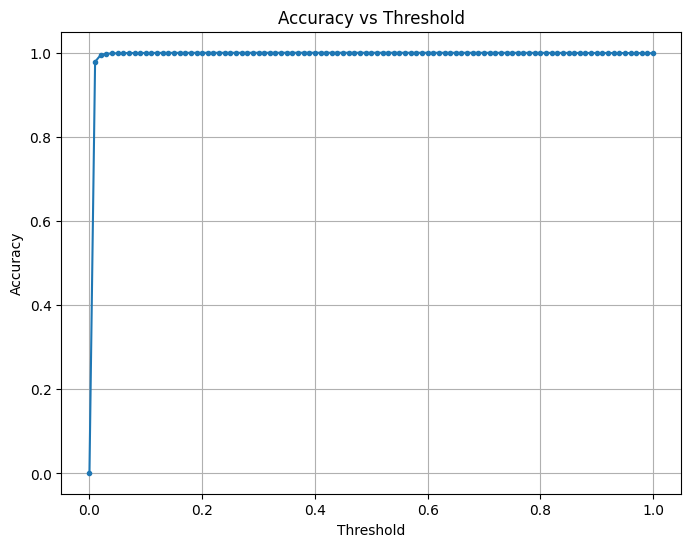

In [6]:
# Accuracy vs threshold

thresholds = np.linspace(0, 1, 101)
accuracies = []
for t in thresholds:
    preds_t = (y_scores >= t).astype(int)
    accuracies.append(accuracy_from_scratch(y_test.values, preds_t))

plt.plot(thresholds, accuracies, marker='o', markersize=3)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Threshold")
plt.grid(True)
plt.show()

In [8]:
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

## Confusion matrix for binary classification

Confusion matrix (binary) layout (our convention):
$$
\begin{bmatrix}
TP & FP \\
FN & TN
\end{bmatrix}
$$

Confusion matrix (binary) layout (sklearn):
$$
\begin{bmatrix}
TN & FP \\
FN & TP
\end{bmatrix}
$$

Where:
- **TP** = true positives
- **FP** = false positives
- **FN** = false negatives
- **TN** = true negatives 


Confusion matrix (scratch):
 [[  114     5]
 [   34 85290]]
Confusion matrix (sklearn):
 [[85290     5]
 [   34   114]]


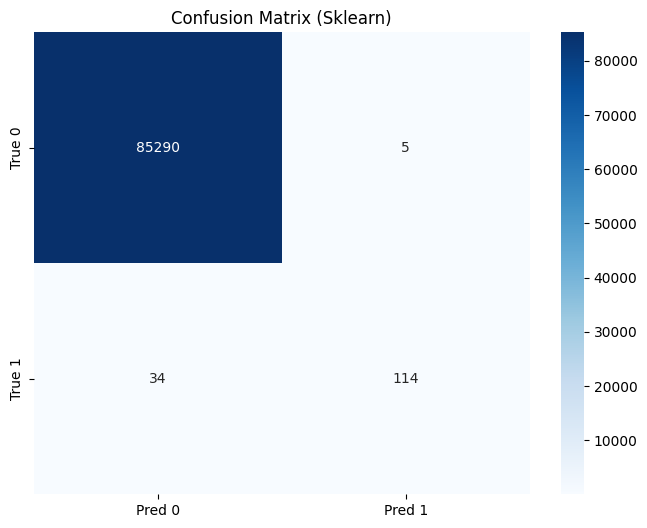

In [7]:
# Confusion matrix (from scratch and sklearn)
def confusion_from_scratch(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    return np.array([[TP, FP], [FN, TN]])

cm_scratch = confusion_from_scratch(y_test.values, y_pred_05)
cm_sklearn = confusion_matrix(y_test, y_pred_05)
print("Confusion matrix (scratch):\n", cm_scratch)
print("Confusion matrix (sklearn):\n", cm_sklearn)

# Visualize as heatmap for clarity
sns.heatmap(cm_sklearn, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'])
plt.title("Confusion Matrix (Sklearn)")
plt.show()


# Precision (Positive Predictive Value)

**Definition:**  

$$\text{Precision} = \frac{TP}{TP + FP}$$


**Use-case:** When **false positives are costly** (e.g., in spam detection, incorrectly classifying a legitimate email as spam).

Precision varies with threshold; higher thresholds usually increase precision (fewer predictions labeled positive → less FP) but can reduce recall.

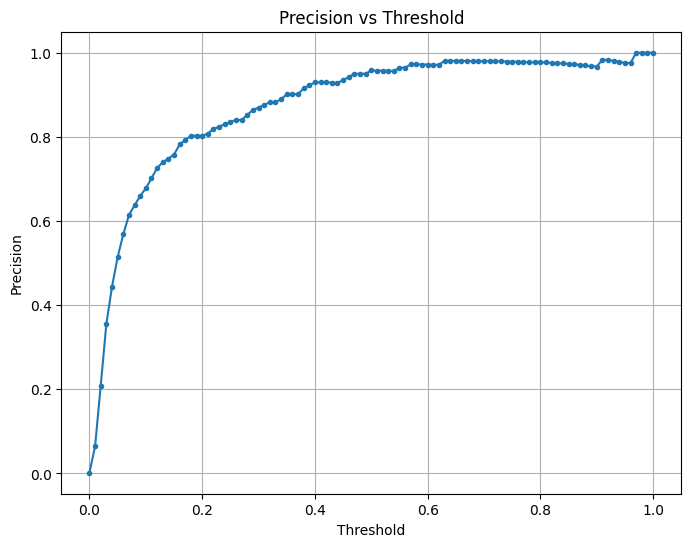

Precision at threshold 0.5 (scratch): 0.95798
Precision at threshold 0.5 (sklearn): 0.95798


In [10]:
# Precision vs threshold 
def precision_from_scratch(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    return TP / (TP + FP) if (TP + FP) > 0 else 0.0

precisions = []
for t in thresholds:
    preds_t = (y_scores >= t).astype(int)
    precisions.append(precision_from_scratch(y_test.values, preds_t))

plt.plot(thresholds, precisions, marker='o', markersize=3)
plt.xlabel("Threshold")
plt.ylabel("Precision")
plt.title("Precision vs Threshold")
plt.grid(True)
plt.show()

print(f"Precision at threshold 0.5 (scratch): {precision_from_scratch(y_test, y_pred_05):.5f}")
print(f"Precision at threshold 0.5 (sklearn): {precision_score(y_test, y_pred_05):.5f}")


## True Positive Rate (TPR)/ Recall/ Sensitivity

**Definition:**  

$$\text{Recall (TPR)} = \frac{TP}{TP + FN}$$


**Use-case:** When **false negatives are costly** (e.g., medical diagnosis — missing a disease).  

Recall usually *increases* when threshold decreases (more positives predicted → fewer FNs).


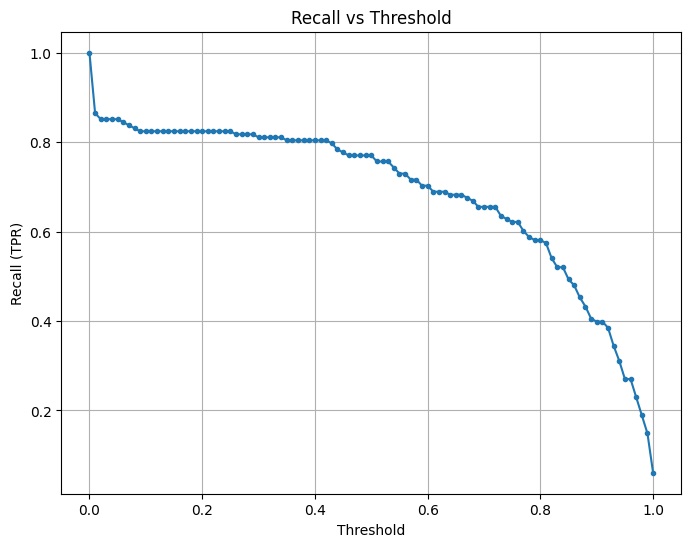

Recall at 0.5 (sklearn): 0.7702702702702703


In [11]:
# Recall vs threshold
def recall_from_scratch(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return TP / (TP + FN) if (TP + FN) > 0 else 0.0

recalls = []
for t in thresholds:
    preds_t = (y_scores >= t).astype(int)
    recalls.append(recall_from_scratch(y_test.values, preds_t))

plt.plot(thresholds, recalls, marker='o', markersize=3)
plt.xlabel("Threshold")
plt.ylabel("Recall (TPR)")
plt.title("Recall vs Threshold")
plt.grid(True)
plt.show()

print("Recall at 0.5 (sklearn):", recall_score(y_test, y_pred_05))

## Precision-Recall Curve

The PR curve plots **Precision** (y-axis) vs **Recall** (x-axis) as the decision threshold varies.


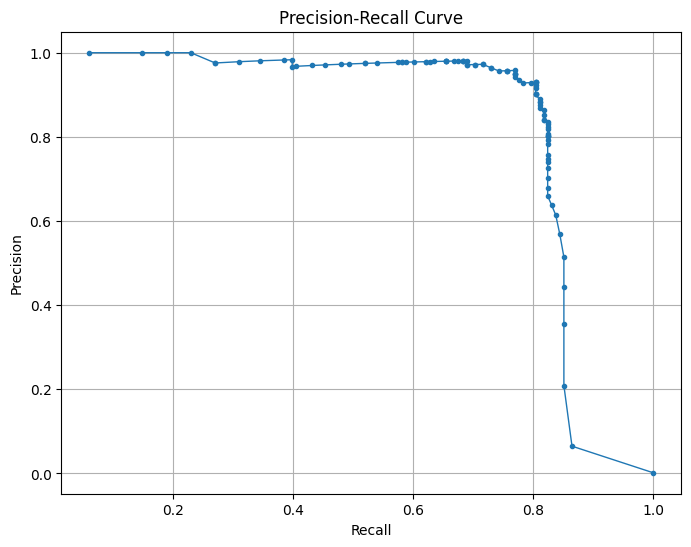

In [12]:
# Precision-Recall curve (from scratch)

plt.plot(recalls, precisions, marker='.', linewidth=1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

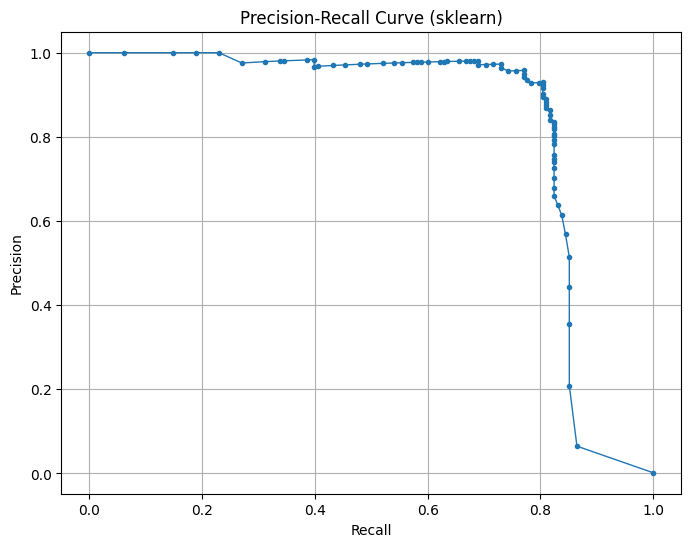

In [13]:
# Precision-Recall curve (sklearn)
prec, rec, pr_thresholds = precision_recall_curve(y_test, y_scores)
# note: sklearn returns precision and recall arrays; thresholds length = len(prec)-1 = len(np.unique(y_scores))

plt.plot(rec, prec, marker='.', linewidth=1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (sklearn)")
plt.grid(True)
plt.show()

In [14]:
len(pr_thresholds)

80

## Area under PR curve (AU PRC) and Average Precision

- AU‑PRC: area under the precision-recall curve (use trapezoidal rule).
- **Average Precision (AP)**: a summary that approximates the area under PR curve, accounting for changes in recall (sklearn `average_precision_score`).

These metrics are preferred on heavily imbalanced datasets when we care about positive class performance.


In [16]:
# AU PRC (trapezoid) 
# Compute AU-PRC via trapezoidal rule using the curve arrays

au_prc_trapz = np.trapezoid(rec, prec)  # area under precision(recall)

# average precision i sklearn (which is a summary that approximates the area under PR curve)
avg_precision = average_precision_score(y_test, y_scores)

print(f"AU-PRC (trapezoid): {au_prc_trapz:.6f}")
print(f"Average Precision (sklearn): {avg_precision:.6f}")


AU-PRC (trapezoid): 0.827053
Average Precision (sklearn): 0.822702


## F‑beta score

**Definition**:
$$
F_\beta = (1+\beta^2) \cdot \frac{\text{Precision} \cdot \text{Recall}}{(\beta^2 \cdot \text{Precision}) + \text{Recall}}
$$
- $\beta < 1$ emphasizes **precision** (e.g., $\beta=0.5$)
- $\beta > 1$ emphasizes **recall** (e.g., $\beta=2$)
- $\beta = 1$ → F1 (harmonic mean of precision & recall)

We'll compute F‑beta across thresholds for $\beta \in \{0.2, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0\}$.


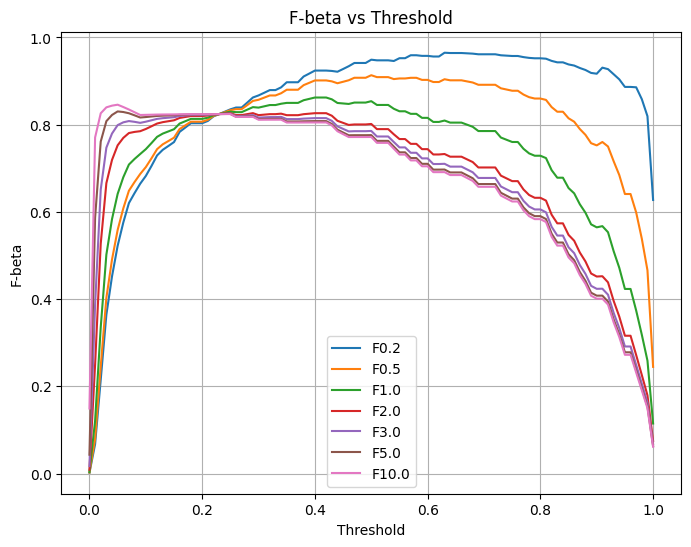

F1 (sklearn) at threshold = 0.5: 0.8539325842696629
F0.5 (sklearn) at threshold = 0.5: 0.9134615384615384
F2 (sklearn) at threshold = 0.5: 0.8016877637130801


In [17]:
# F-beta vs threshold (from scratch)

def fbeta_from_precision_recall(prec, rec, beta):
    b2 = beta**2
    denom = (b2 * prec) + rec
    return (1 + b2) * (prec * rec) / denom if denom > 0 else 0.0

betas = [0.2, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0]
fbeta_vals = {b: [] for b in betas}

for t in thresholds:
    preds_t = (y_scores >= t).astype(int)
    p = precision_from_scratch(y_test.values, preds_t)
    r = recall_from_scratch(y_test.values, preds_t)
    for b in betas:
        fval = fbeta_from_precision_recall(p, r, b)
        fbeta_vals[b].append(fval)

for b in betas:
    plt.plot(thresholds, fbeta_vals[b], label=f"F{b}")
plt.xlabel("Threshold")
plt.ylabel("F-beta")
plt.title("F-beta vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

# show F1 at 0.5 threshold via sklearn
print("F1 (sklearn) at threshold = 0.5:", f1_score(y_test, y_pred_05))

# show F-beta at 0.5 threshold via sklearn
print("F0.5 (sklearn) at threshold = 0.5:", fbeta_score(y_test, y_pred_05, beta=0.5))
print("F2 (sklearn) at threshold = 0.5:", fbeta_score(y_test, y_pred_05, beta=2.0))


## False Positive Rate (FPR)

**Definition:**

$$\text{FPR} = \frac{FP}{FP + TN}$$

FPR is the proportion of negatives incorrectly labeled positive. It varies with threshold (lower threshold → higher FPR).


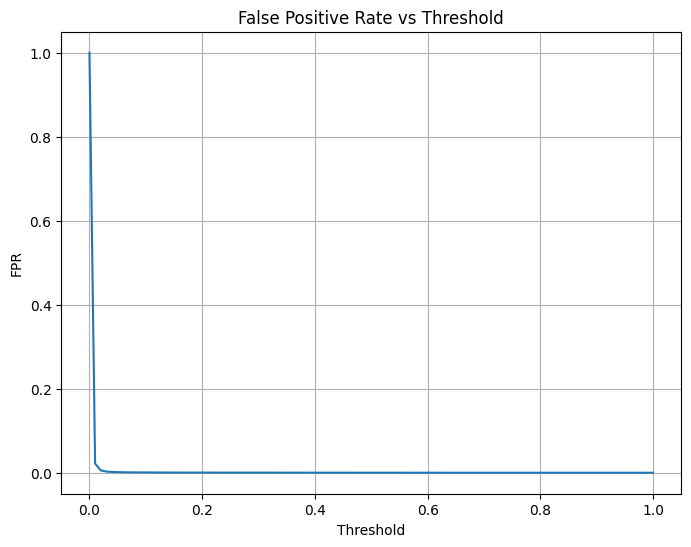

In [18]:
# FPR vs threshold
def fpr_from_scratch(y_true, y_pred):
    FP = np.sum((y_true == 0) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    return FP / (FP + TN) if (FP + TN) > 0 else 0.0

fprs = []
for t in thresholds:
    preds_t = (y_scores >= t).astype(int)
    fprs.append(fpr_from_scratch(y_test.values, preds_t))

plt.plot(thresholds, fprs)
plt.xlabel("Threshold")
plt.ylabel("FPR")
plt.title("False Positive Rate vs Threshold")
plt.grid(True)
plt.show()

## False Negative Rate (FNR)

**Definition:**

$$\text{FNR} = \frac{FN}{TP + FN} = 1 - \text{Recall}$$

FNR is the proportion of positives missed by the model. It decreases as threshold decreases (more predicted positives).


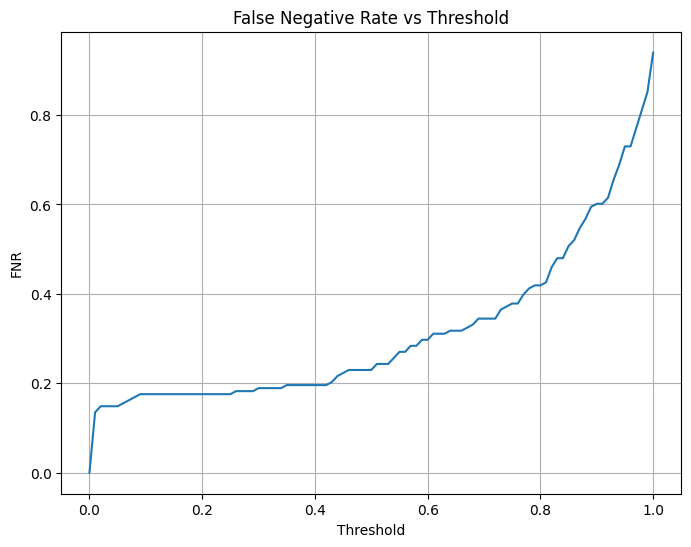

In [19]:
# FNR vs threshold
fnrs = []
for t in thresholds:
    preds_t = (y_scores >= t).astype(int)
    # FNR = FN / (TP+FN)
    TP = np.sum((y_test.values == 1) & (preds_t == 1))
    FN = np.sum((y_test.values == 1) & (preds_t == 0))
    fnrs.append(FN / (TP + FN) if (TP + FN) > 0 else 0.0)

plt.plot(thresholds, fnrs)
plt.xlabel("Threshold")
plt.ylabel("FNR")
plt.title("False Negative Rate vs Threshold")
plt.grid(True)
plt.show()


## True Negative Rate (TNR / Specificity)

**Definition:**

$$ \text{TNR (Specificity)} = \frac{TN}{TN + FP} = 1 - \text{FPR} $$

TNR is the proportion of negatives correctly identified.


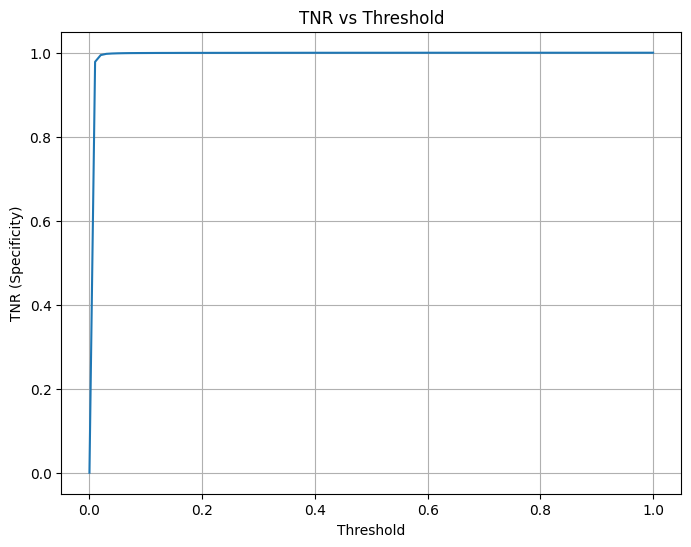

In [20]:
# TNR vs threshold

tnrs = [1 - f for f in fprs]  # since TNR = 1 - FPR
plt.plot(thresholds, tnrs)
plt.xlabel("Threshold")
plt.ylabel("TNR (Specificity)")
plt.title("TNR vs Threshold")
plt.grid(True)
plt.show()


## Receiver Operating Characteristic (ROC) curve

ROC plots **TPR / Sensitivity/ Recall** (y-axis) vs **FPR or 1-Specificity** (x-axis) as threshold varies.

ROC‑AUC is the area under this curve; it measures how well the model separates classes.

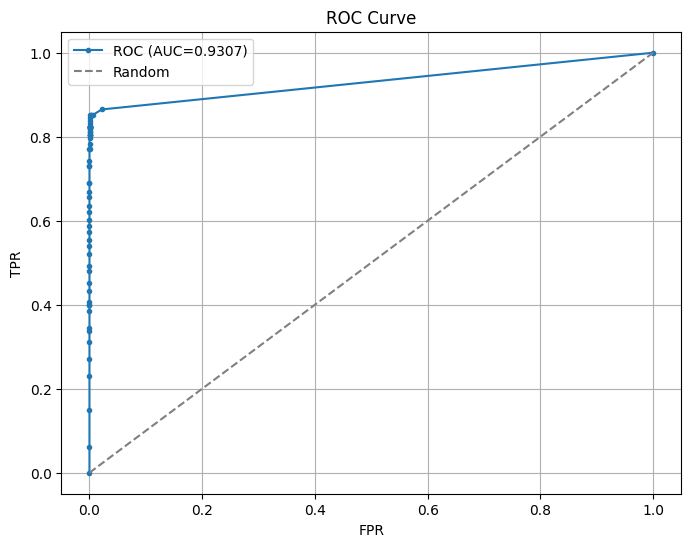

ROC AUC (sklearn): 0.9307394606635477
ROC AUC (trapezoid): 0.9307394606635477


In [21]:
# ROC curve and AUC (sklearn)
fpr_arr, tpr_arr, roc_thresholds = roc_curve(y_test, y_scores)

plt.plot(fpr_arr, tpr_arr, marker='.', label=f"ROC (AUC={roc_auc_score(y_test, y_scores):.4f})")
plt.plot([0,1],[0,1], linestyle='--', color='gray', label='Random')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Compute AUC with trapezoid rule
auc_trapz = np.trapezoid(tpr_arr, fpr_arr)
print("ROC AUC (sklearn):", roc_auc_score(y_test, y_scores))
print("ROC AUC (trapezoid):", auc_trapz)


## Choosing thresholds — example tradeoffs

- If **precision** is critical, choose a **higher threshold** (fewer positives predicted, fewer FP).
- If **recall** is critical, choose a **lower threshold** (catch more positives, but more FP).
- Use F‑beta to encode relative importance of precision vs recall and pick threshold that maximizes chosen F‑beta.

In [22]:
# Example: choose threshold maximizing F1, F0.5, F2
best = {}
for beta in [0.5, 1.0, 2.0]:
    best_score = -1
    best_t = None
    for i, t in enumerate(thresholds):
        p = precisions[i] if i < len(precisions) else precision_from_scratch(y_test.values, (y_scores >= t).astype(int))
        r = recalls[i] if i < len(recalls) else recall_from_scratch(y_test.values, (y_scores >= t).astype(int))
        f = fbeta_from_precision_recall(p, r, beta)
        if f > best_score:
            best_score = f.item()
            best_t = t.item()
    best[beta] = (best_t, best_score)

best


{0.5: (0.5, 0.9134615384615385),
 1.0: (0.4, 0.8623188405797102),
 2.0: (0.25, 0.8265582655826558)}

## Summary table of selected metrics at different thresholds

We'll build a small DataFrame that shows metrics at a few thresholds (0.01, 0.05, 0.1, 0.2, 0.5).


In [23]:
# Summary DataFrame

sample_thresholds = [0.01, 0.05, 0.1, 0.2, 0.5]
rows = []
for t in sample_thresholds:
    preds = (y_scores >= t).astype(int)
    TP = np.sum((y_test.values == 1) & (preds == 1))
    FP = np.sum((y_test.values == 0) & (preds == 1))
    FN = np.sum((y_test.values == 1) & (preds == 0))
    TN = np.sum((y_test.values == 0) & (preds == 0))
    prec = precision_from_scratch(y_test.values, preds)
    rec = recall_from_scratch(y_test.values, preds)
    acc = accuracy_from_scratch(y_test.values, preds)
    f1 = fbeta_from_precision_recall(prec, rec, 1.0) if (prec+rec)>0 else 0.0
    rows.append({
        'threshold': t, 'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN,
        'precision': prec, 'recall': rec, 'accuracy': acc, 'F1': f1
    })
summary_df = pd.DataFrame(rows)
summary_df.set_index('threshold', inplace=True)
summary_df


,TP,FP,FN,TN,precision,recall,accuracy,F1
threshold,,,,,,,,
0.01,128,1846,20,83449,0.064843,0.864865,0.978161,0.120641
0.05,126,119,22,85176,0.514286,0.851351,0.998350,0.641221
0.10,122,58,26,85237,0.677778,0.824324,0.999017,0.743902
0.20,122,30,26,85265,0.802632,0.824324,0.999345,0.813333
0.50,114,5,34,85290,0.957983,0.770270,0.999544,0.853933


## Notes

- For **highly imbalanced** datasets:
  - Use **Precision-Recall** curves and **AU-PRC** & **Average Precision** as primary performance summaries for the positive (rare) class.
  - ROC-AUC can still be informative but sometimes overly optimistic because it equally weights TPR and FPR across thresholds.

- For operational use, pick an **explicit threshold** tied to business constraints (cost of FP vs FN). Consider expected costs and compute expected utility.
